In [80]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# Policy Iteration

Here, we implement the grid world example from the RL Lecture 3 by Davin Silver for policy iteration [see example](https://youtu.be/Nd1-UUMVfz4?t=1618)

Given an initial policy $\pi$ _Policy iteration_ is done by iteratively evaluating the policy and then improving it by acting greedily w.r.t to $v_\pi$

$$
\pi' = greedy(v_\pi)
$$

This algorithm always converges to the optimal policy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotting
plotting.set_layout(drawing_size=15)


## Define the Environment

* In every state (except goal state) a moment has a cost of -1
* In a goal state, thers is no cost for moving
* If the agent is in a goal state, do not execute any moevement


In [2]:

class environment():
    """ This class defines all the necessary properties of the environment. 
        For now, the environment is a nxn rectangular grid"""
    
    def __init__(self,n=5,s_start=(0,0),s_goals=[(4,4)]):
        """ n: defines the length and width of the environment
            s_start: defines the starting position of the agent (x-,y-position)
            """ 
        
        # Define the grid
        self.n_grid = n
        
        # Agent position
        self.x_agent = s_start[0]
        self.y_agent = s_start[1]
        # Agent actions
        self.actions = ['n','e','s','w']
        
        # Define rewards
        self.rewards = np.ones((n,n)) * (-1)
        # Define goal states
        self.s_goals = s_goals
        for g_i,g in enumerate(s_goals):
            self.rewards[g] = 0
            
            
            
    
    
    def move(self,a=None,state=None):
        """ Moves the agent from its current state to the next state given action a
            and returns a reward for that movement (cost of current state or new state ??)
            a: is the action
            state: is optional and can be the state from which the action is executed
            
        """

        assert(a in self.actions)
        
        # If state is given, use it as an indication that the movement is just simulated.
        # Do not update internal states
        if state:
            x_s = state[0]
            y_s = state[1]
        else:
            x_s = self.x_agent
            y_s = self.y_agent
            
        # If agent is in a goal state, do not move anymore
        if (x_s, y_s) in self.s_goals:
            return x_s,y_s
        
        x = x_s
        y = y_s
        
        # execute movement. For now, the environment is deterministic
        if a == 'n':
            y = y -1
        if a == 's':
            y = y +1
        if a == 'e':
            x = x +1
        if a == 'w':
            x = x -1
        
        # make sure to stay in the environment. if an acion moves the agent outside, just remain in current state
        if x < 0 or y < 0 or x >= self.n_grid or y >= self.n_grid:
            # do nothing and return rewards of current state
            return x_s,y_s
        else:
            # set new state and return rewards of new state
            
            # update internal variables if its a real movement
            if state:
                pass
            else:
                self.x_agent = x
                self.y_agent = y
            return x,y
    
    def get_reward(self, state):
        # Returns the reward for a given state
        return self.rewards[state[0],state[1]]
        
    
    def plot_env(self):
        """ Plots the with the agent's position and rewars"""
        
        fig = plt.figure(figsize=(10,5))
        
        axes = fig.subplots(1,2)
        
        # Agent's position
        ax = axes[0]
        grid = np.zeros((self.n_grid,self.n_grid))
        grid[self.y_agent,self.x_agent] = 0.01
        ax.matshow(grid, cmap='jet')
        ax.set_title('Agent\'s Position')

        # Rewards
        ax = axes[1]
        ax.matshow(self.rewards)
        
        for (i, j), z in np.ndenumerate(self.rewards):
            ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
        ax.set_title('Rewards')

            
        plt.show()
        


## Define the Agent

Agent stores:
* The policy
* value function
* It has a model of the environment

In [76]:

class agents():
    """ This class defines the agent 
    """
    
    def __init__(self,n=5, gamma=1, pos_start=(0,0),env=None):
        """ n: defines the length and width of the environment
            gamma: the discount factor
            pos_start: defines the starting position of the agent (x-,y-position)
            env: an environment class to use as an internal model
            """ 
        
        if env:
            self.model_env = env
        else:
            print('No environment given. Cannot simulate movements')
        
        # Store the discount factor 
        self.gamma = gamma
        
        # Store size of environment
        self.n_grid = n
        
        # set the starting position
        self.x = pos_start[0]
        self.y = pos_start[1]
            
        # Store the value function for each state
        # start with zero
        self.v = np.zeros((n,n))
        
        # Initialize the policy
        # initially the probability to choose an action given a state is 1/4 
        self.policy = np.ones((self.n_grid,self.n_grid,len(self.model_env.actions))) / 4
        
        # Define transition matrix P^a_ss
        self.P = np.zeros((self.n_grid,self.n_grid,len(self.model_env.actions)))
    

        
        
    
    def random_move(self):
        # Chooses a random movement (independent of the state)
        i = np.random.randint(0,len(self.actions))
        return self.actions[i]
    
    
    def udate_policy(self):
        # this function should be called after policy_evaluation
        
        p = np.copy(self.policy)
        
        # For each state check which is the best movement to do. Update the policy accordingly
        # walk over all states
        for i in range(np.size(self.v,0)):
            for ii in range(np.size(self.v,1)):
                # walk over all actions calculate the value of the resulting state and store it
                l = []
                for a_i,a_probability in enumerate(self.policy[i,i]):
                    # walk over alle possible reachable states given that acion
                    if a_i == 0:
                        a = 'n'
                    if a_i == 1:
                        a = 'e'
                    if a_i == 2:
                        a = 's'
                    if a_i == 3:
                        a = 'w'
                    x,y = self.model_env.move(a,(i,ii))
                    l.append(self.v[x,y])
                    
                    
                # check if all entries are the same
                if np.max(l) != np.min(l):
                    # what about if two entries are similar?
                    winner = np.argwhere(l == np.amax(l))
                    p[i,ii] = np.zeros(4)
                    # update policy
                    p[i,ii,winner] = 1.0
                        
        self.policy = p
    
    def policy_evaluation(self):
        # Given the reward update the value function of all states
#         self.v[self.y,self.x] = r + self.gamma * np.sum(  ) 
        v = np.zeros(self.v.shape)
        # walk over all states
        for i in range(np.size(self.v,0)):
            for ii in range(np.size(self.v,1)):
                # walk over all actions accoriding to the policy
                for a_i,a_probability in enumerate(self.policy[i,i]):
                    # walk over alle possible reachable states given that acion
                    if a_i == 0:
                        a = 'n'
                    if a_i == 1:
                        a = 'e'
                    if a_i == 2:
                        a = 's'
                    if a_i == 3:
                        a = 'w'
                            
                    # simulate movement
                    x,y = self.model_env.move(a,(i,ii))
                    v[i,ii] += a_probability * ( self.model_env.rewards[i,ii] + self.gamma * self.v[x,y])
        
        self.v = np.copy(v)

        

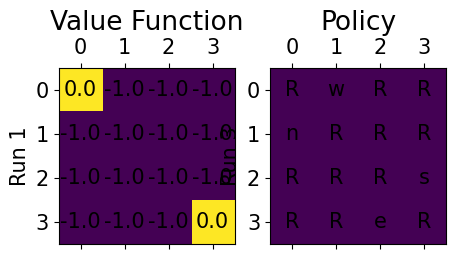

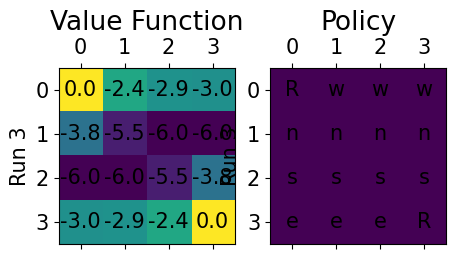

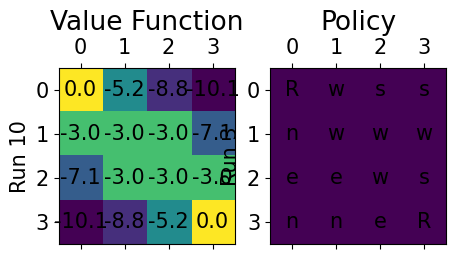

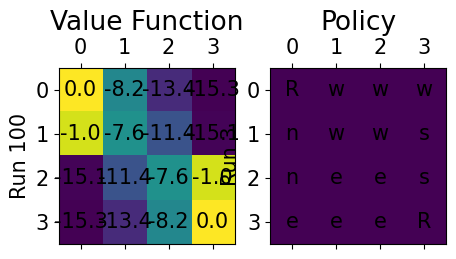

In [78]:
# Set up the environmental variables
n = 4
agent_start = (1,1)
goal_states = [(0,0),(3,3)]
gamma = 1

# initialize everything
env = environment(n=n, s_start=agent_start,s_goals=goal_states)
agent = agents(n=n, gamma = gamma, pos_start=agent_start,env=env)


# run the policy iteration
for i in range(100):
    agent.policy_evaluation()
    agent.udate_policy()

#     if i>5:
#         agent.udate_policy()

    i = i+1

    if i==0 or i == 1 or i == 3 or i == 10 or i == 100:
        # plot the results
        fig =plt.figure(figsize=(5,5))
        axes = fig.subplots(1,2)
#         if i == 100:

#         print(agent.policy)

        
        ax = axes[0]
        c = ax.matshow(agent.v)
        for (k, j), z in np.ndenumerate(agent.v):
            ax.text(j, k, '{:0.1f}'.format(z), ha='center', va='center')
        ax.set_ylabel('Run {0:}'.format(i))
        ax.set_title('Value Function')
        
        ax = axes[1]
        
        # visualize the policy
        p_vis = np.chararray((n,n))
        for i in range(np.size(agent.policy,0)):
            for ii in range(np.size(agent.policy,1)): 
                # translate policy into movement characters
                if np.all(0.25 == agent.policy[i,ii]):
                    p_vis[i,ii] = 'R'
                else:
                    # this decoding is upside-down!
                    a_i = np.argmax(agent.policy[i,ii])
                    if a_i == 0:
                        a = 'w'
                    if a_i == 1:
                        a = 's'
                    if a_i == 2:
                        a = 'e'
                    if a_i == 3:
                        a = 'n'
                    p_vis[i,ii] = a
                    
                    
        
        c = ax.matshow(np.zeros((n,n)))
        for (k, j), z in np.ndenumerate(p_vis):
            ax.text(j, k, z.decode(), ha='center', va='center')
        ax.set_ylabel('Run {0:}'.format(i))
        ax.set_title('Policy')
        plt.show()        